In [30]:
using PyPlot
using LinearAlgebra
using PyPlot

include("../smear_fem/src/fem.jl")
include("../smear_fem/src/PostProcess.jl")

Main.PostProcess

In [31]:
# test case 
# test case 
x0 = 0
x1 = 1
y0 = 0
y1 = 1
z0 = 0
z1 = 1
ne = 11
ndim = 3
FunctionClass = "Q1";

In [32]:
# set up mesh grid
function meshgrid(x0,x1,y0,y1,z0,z1,ne,ndim)

    NodeList = zeros(ndim,(ne+1)^ndim)
    IEN = zeros(Int64,ne^ndim,2^ndim)

    if ndim == 2
        x = collect(range(x0, x1, length=ne+1))
        y = collect(range(y0, y1, length=ne+1))
    
        k = 1
        for i in 1:ne+1
            for j in 1:ne+1
                NodeList[1,k] = x[j]
                NodeList[2,k] = y[i]
                k = k + 1
            end
        end
        
        l = 1
        for i in 1:ne
            for j in 1:ne
                IEN[l,1] = (i-1)*(ne+1) + j
                IEN[l,2] = (i-1)*(ne+1) + j + 1
                IEN[l,3] = i*(ne+1) + j + 1
                IEN[l,4] = i*(ne+1) + j
                l = l + 1
            end
        end

    elseif ndim == 3

        x = collect(range(x0, x1, length=ne+1))
        y = collect(range(y0, y1, length=ne+1))
        z = collect(range(z0, z1, length=ne+1))
        
        m = 1
        for k in 1:ne+1
            for j in 1:ne+1
                for i in 1:ne+1
                    NodeList[1,m] = x[i]
                    NodeList[2,m] = y[j]
                    NodeList[3,m] = z[k]
                    m = m + 1
                end
            end
        end
        
        l = 1
        for k in 1:ne
            for i in 1:ne
                for j in 1:ne
                    IEN[l,1] = (k-1)*(ne+1)^2 + (i-1)*(ne+1) + j
                    IEN[l,2] = (k-1)*(ne+1)^2 + (i-1)*(ne+1) + j + 1
                    IEN[l,3] = (k-1)*(ne+1)^2 + i*(ne+1) + j + 1
                    IEN[l,4] = (k-1)*(ne+1)^2 + i*(ne+1) + j
                    IEN[l,5] = k*(ne+1)^2 + (i-1)*(ne+1) + j
                    IEN[l,6] = k*(ne+1)^2 + (i-1)*(ne+1) + j + 1
                    IEN[l,7] = k*(ne+1)^2 + i*(ne+1) + j + 1
                    IEN[l,8] = k*(ne+1)^2 + i*(ne+1) + j
                    l = l + 1
                end
            end
        end
    end

    return NodeList, IEN
end

NodeList, IEN = meshgrid(x0,x1,y0,y1,z0,z1,ne,ndim)


([0.0 0.09090909090909091 … 0.9090909090909091 1.0; 0.0 0.0 … 1.0 1.0; 0.0 0.0 … 1.0 1.0], [1 2 … 158 157; 2 3 … 159 158; … ; 1570 1571 … 1727 1726; 1571 1572 … 1728 1727])

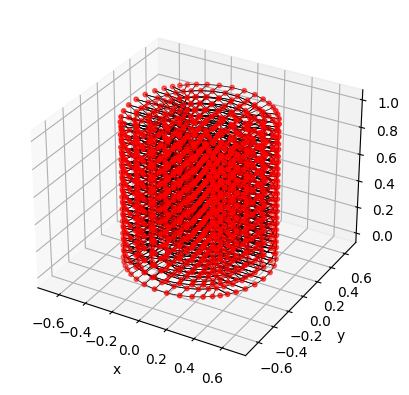

In [33]:
NodeListCyl = PostProcess.inflate_sphere(NodeList, x0, x1, y0, y1)

PostProcess.PlotMesh(NodeListCyl, IEN)


In [57]:
CameraMatrix = [[8*2048/7.07, 0.0, 2048/2] [0.0, 8*1536/5.3, 1536/2] [0.0, 0.0, 1.0]]

function backProject(NodeList, CameraMatrix)
""" Project the 3D mesh to 2D image plane

Args:
    NodeList: 3D mesh grid
    IEN: connectivity matrix
    ndim: dimension of the mesh grid

Returns:
    NodeList: 2D mesh grid
"""
    # transform point cloud wrt to camera frame 
    # camera frame
    R = [1 0 0; 0 0 1; 0 -1 0]
    t = [0; -0.5; 5]
    NodeListTrans = R*NodeList .+ t

    NodeListNorm = zeros(3,size(NodeListTrans,2))

    for i in 1:size(NodeListNorm,2)
        NodeListNorm[1,i] = NodeListTrans[1,i]/NodeListTrans[3,i]
        NodeListNorm[2,i] = NodeListTrans[2,i]/NodeListTrans[3,i]
        NodeListNorm[3,i] = NodeListTrans[3,i]/NodeListTrans[3,i]
    end
    
    # project the 3D mesh to 2D image plane
    NodeListProj = CameraMatrix'*NodeListNorm

    NodeList2D = NodeListProj[1:2,:]

    return NodeList2D, NodeListTrans, NodeListNorm

backProject (generic function with 1 method)

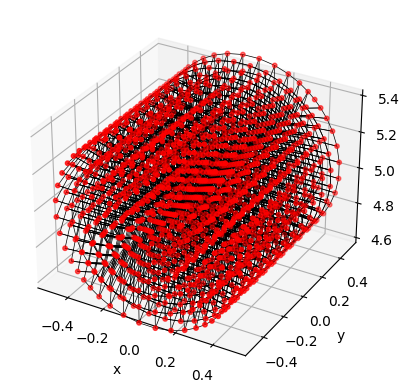

In [58]:
NodeList2D, NodeListTrans, NodeListNorm = backProject(NodeListCyl, CameraMatrix)

PostProcess.PlotMesh(NodeListTrans, IEN)

In [56]:
display(CameraMatrix'*NodeListNorm)

3×1728 Matrix{Float64}:
 870.957  887.795  909.264  936.107  …  1129.5   1159.88  1183.06  1200.33
 551.462  552.806  554.189  555.497     1023.07  1021.21  1019.3   1017.49
   1.0      1.0      1.0      1.0          1.0      1.0      1.0      1.0

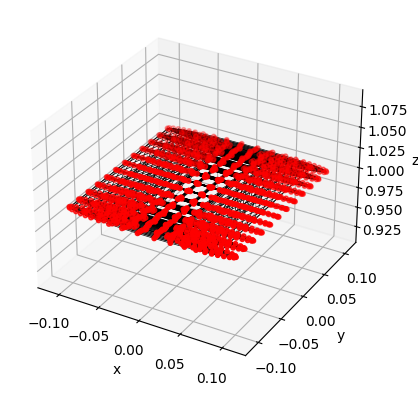

In [59]:
PostProcess.PlotMesh(NodeListNorm, IEN)

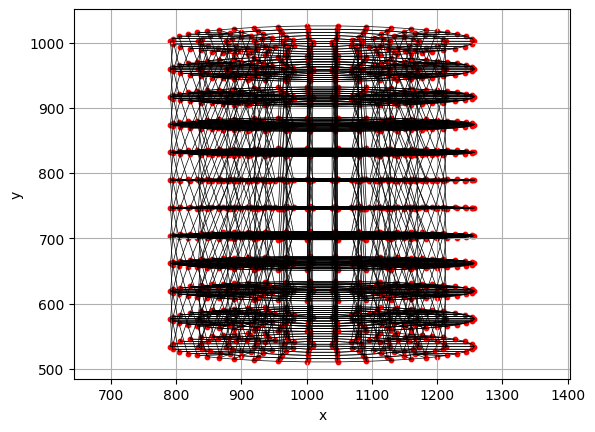

In [60]:
PostProcess.PlotMesh(NodeList2D, IEN)

In [4]:
function setboundaryCond(NodeList, ne, ndim)
    # set dirichlet boundary conditions
    q_d = zeros((ne+1)^ndim,1)
    q_n = zeros((ne+1)^ndim,1)
    Dbound1 = 0
    Dbound2 = 1
    Nbound = 0

    # definition of the constraint matrix
    C = Matrix{Int}(I,(ne+1)^ndim,(ne+1)^ndim)

    for n in 1:length(q_d)
        coord = NodeList[:,n] # get the coordinates of the node
        if coord[2] == Dbound1 # bottom boundary
            q_d[n] = 0
        elseif coord[3] == Dbound2 # top boundary
            q_d[2] = 1
        end

        if coord[1] == Nbound # left boundary
            q_n[n] = 0
        end 
    end

    C = C[:,((ne+1)^(ndim-1)+1):((ne+1)^ndim-(ne+1)^(ndim-1))]
    
    return q_d, q_n, C
end

q_d, q_n, C = setboundaryCond(NodeList, ne, ndim);

BoundsError: BoundsError: attempt to access 2-element Vector{Float64} at index [3]

In [5]:
K = fem.assemble_system(ne, NodeList, IEN, ndim, FunctionClass)

q_d, q_n, C = setboundaryCond(NodeList, ne, ndim)

# transpose the constraint matrix
C_t = transpose(C)

# extract the free part of the stiffness matrix
K_free = C_t*K*C

b = q_n - K*q_d

# solve the system
q_f = K_free\C_t*b

# assemble the solution 
q = q_d + C*q_f;

UndefVarError: UndefVarError: nDof not defined

In [6]:
PostProcess.write_vtk("vtkFiles/isoParam3d","u",NodeList,IEN, ne, ndim, q)

UndefVarError: UndefVarError: q not defined